# Herramientas: Mi primera red neuronal basada en JAX


Para definir y entrenar redes neuronales artificiales con JAX utilizaremos dos librerías:

[Flax](https://flax.readthedocs.io/en/latest/) es una librería de redes neuronales artificiales cuyo foco es la flexibilidad y que utiliza JAX como backend de cómputo, Además tiene interoperabilidad con la librería de programación probabilística *NumPyro*. 

> Flax provee `flax.linen`, una API con primitivas para diseñar redes neuronales (similar a `torch.nn`)

[optax](https://github.com/deepmind/optax) es una librería de optimización numérica para modelos paramétricos basada en JAX. Esta librería provee los algoritmos basados en gradiente descedente que se ocupan típicamente para entrenar redes neuronales artificiales.

## Instalación

Instala utilizando pip:

    pip install flax
    pip install optax


In [1]:
import flax.linen as nn
import optax
import jax

## Definiendo un modelo en `flax`

Un modelo en `flax` es una clase de Python que hereda de `flax.linen.Module`. Existen dos formas de escribir un modelo: explicita o *inline*

En la forma explícitala clase que representa el modelo debe implementar:

- Un método `__call__` que recibe los datos de entrada y retorna una predicción
- Un método `__setup__` que declara las variables y submódulos que componen el modelo 

En la forma *inline* sólo se define `__call__` con un decorador `nn.compact`. Por ejemplo un regresor logístico 

$$
y = \text{sigmoid}\left(\sum_j w_j x_j + b \right)
$$

se implementaría como:

In [2]:
class LogisticRegressor(nn.Module):
    
    @nn.compact
    def __call__(self, x):
        return nn.sigmoid(nn.Dense(1)(x))
    
LogisticRegressor()

LogisticRegressor()

donde `nn.Dense` realiza una transformación lineal de tipo WX + B.

> El decorador se hace cargo de registrar los parámetros de los submódulos como `nn.Dense`. 

Implementemos ahora el siguiente modelo tipo *multi layer perceptron* con una capa oculta y sin activación de salida (modelo regresor)

$$
y = \left(\sum_j w_j \text{ReLU}\left( \sum_i w_{ij} x_i + b_i\right) + b \right)
$$


In [3]:
class MLP_singlehidden(nn.Module):
    
    hidden_neurons: int
    output_neurons: int
        
    @nn.compact
    def __call__(self, x):
        z = nn.relu(nn.Dense(self.hidden_neurons)(x))
        return nn.Dense(self.output_neurons)(z)
   
MLP_singlehidden(10, 2)

MLP_singlehidden(
    # attributes
    hidden_neurons = 10
    output_neurons = 2
)

Podemos pasar argumentos al momento de construir el objeto definiendolos dentro de la clase con la notación

    nombre_variable : tipo_variable
    
:::{note}

`flax` implementa clases de tipo `dataclass` (introducidas en Python 3.7)

:::

Veamos ahora como se implementaría un modelo MLP con 

- número arbitrario de capas ocultas
- función de activación a elección (por defecto relu)

In [4]:
from typing import Sequence, Callable

class MLP(nn.Module):
    
    neurons_per_layer: Sequence[int]
    activation: Callable = nn.relu
    
    @nn.compact
    def __call__(self, x):
        for k, neurons in enumerate(self.neurons_per_layer):
            x = nn.Dense(neurons)(x)
            if k != len(self.neurons_per_layer) - 1:
                x = self.activation(x)
        return x
    
MLP(neurons_per_layer=[10, 5, 3])

MLP(
    # attributes
    neurons_per_layer = [10, 5, 3]
    activation = relu
)

Otros submódulos y funciones útiles de `flax.linen` por categoría:

- [Capas densas y convolucionales](https://flax.readthedocs.io/en/latest/flax.linen.html#linear-modules)
- [Capas de pooling](https://flax.readthedocs.io/en/latest/api_reference/flax.linen.html#pooling)
- [Funciones de activación](https://flax.readthedocs.io/en/latest/flax.linen.html#activation-functions)
- [Capas recurrentes](https://flax.readthedocs.io/en/latest/flax.linen.html#rnn-primitives)
- [Capas de batch normalization](https://flax.readthedocs.io/en/latest/flax.linen.html#normalization)
- [Atención](https://flax.readthedocs.io/en/latest/api_reference/flax.linen.html#attention-primitives)


## Métodos `init` y `apply`

Consideremos el último modelo definido:

In [5]:
model = MLP(neurons_per_layer=[10, 10, 1])

:::{important}

`model` guarda la arquitectura del modelo pero no los valores de sus parámetros (peso). En `flax` los parámetros se manejan por separado

:::

Para inicializar los pesos del modelo utilizamos el método `init`, el cual espera 

- una llave pseudo aleatoria consumible. Podemos generarla con `jax.random.PRNGKey`
- un tensor de ejemplo que tenga las dimensiones de nuestros datos

In [6]:
import jax.random as random
import jax.numpy as jnp

key = random.PRNGKey(12345) # 12345 es la semilla para el PRNG
params = model.init(key, jnp.zeros(shape=(1, 1)))
params

FrozenDict({
    params: {
        Dense_0: {
            kernel: DeviceArray([[-1.0674667 , -0.06264212,  0.42956862,  1.2786232 ,
                          -0.74584633,  1.1691928 ,  1.4219344 , -0.5895175 ,
                           0.5620119 ,  0.83076704]], dtype=float32),
            bias: DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
        },
        Dense_1: {
            kernel: DeviceArray([[ 0.08284923, -0.38116872, -0.12968694,  0.36474282,
                          -0.42905015, -0.03718745, -0.2860297 ,  0.07171737,
                           0.00070555, -0.10588341],
                         [-0.20831482,  0.2779922 ,  0.05534944,  0.09165573,
                           0.28945303, -0.10700346,  0.01279914, -0.5825432 ,
                           0.18495017,  0.03577514],
                         [ 0.03020477, -0.4052631 , -0.0723141 ,  0.3378119 ,
                           0.00362646,  0.18239951,  0.10729557,  0.6282217 ,
                    

Luego para hacer una inferencia utilizamos el método `apply` de `model`

Este método recibe el diccionario de parámetros y los datos a evaluar:

In [7]:
x_test = jnp.linspace(-1.25, 1.25, num=200)[:, jnp.newaxis]
y_test = model.apply(params, x_test)

x_test.shape, y_test.shape

((200, 1), (200, 1))

## Ajustando el modelo con `optax`

Entrenaremos un regresor basado en el modelo MLP que vimos anteriormente sobre los siguientes datos sintéticos:

In [8]:
key = random.PRNGKey(0)
key, key_ = random.split(key)

x = jnp.sort(random.uniform(key_, minval=-1, maxval=1, shape=(40, 1)))
f = lambda x : x*jnp.sin(5*x)

key, key_ = random.split(key)
y = f(x) + 0.1*random.normal(key_, shape=x.shape)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
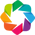

:Points   [x,y]

In [9]:
import holoviews as hv
hv.extension('bokeh')

data_plot = hv.Points((x.ravel(), y.ravel()), label='Train data').opts(width=500, size=5, color='black')
data_plot

Para ajustar el modelo a estos datos utilizaremos la librería de JAX `optax`:

- [Funciones de costo comunes implementadas en `optax`](https://optax.readthedocs.io/en/latest/api.html#common-losses)
- [Algoritmos de optimización implementados en `optax`](https://optax.readthedocs.io/en/latest/api.html#common-optimizers)

En este caso (regresión de funciones) utilizaremos el error medio cuadrático como función de costo:

$$
L = \frac{1}{N} \sum_{i=1}^N (y_i - f_\theta(x_i))^2
$$

donde $f_\theta$ representa el modelo y $\theta$ la colección de parámetros del mismo. Tradicionalmente, el entrenamiento de redes neuronales artificiales se realiza minimizando la función de costo con el algoritmo de gradiente descendente:

$$
\theta_{t+1} = \theta_t - \eta \frac{dL}{d\theta}
$$

En este ejemplo particular utilizaremos el algoritmo de optimización [Adam](https://arxiv.org/abs/1412.6980), un algoritmo de gradiente descedente con paso (tasa de aprendizaje) adaptativa.

La función de costo y el optimizador serían:

In [10]:
optimizer = optax.adam(learning_rate=1e-2)

def loss(params, x, y):
    return jnp.mean((model.apply(params, x) - y)**2)

El optimizador tiene los siguientes métodos

- `init`: Recibe los parámetros iniciales y retorna el "estado" inicial del optimizador
- `update`: Recibe los gradientes de la función de costo, el "estado" actual del optimizador y los parámetros actuales del modelo. Retorna la diferencia entre los parámetros nuevos y actuales, y también el estado actualizado

:::{note}

El "estado" del optimizador se encarga de mantener las variables particulares de cada optimizador, como por ejemplo los estadísticos de los gradientes en el caso de Adam

:::

Inicializamos el modelo y el optimizador con sus métodos `init` respectivos:

In [11]:
key = random.PRNGKey(12345)
model = MLP(neurons_per_layer=[10, 10, 1], activation=nn.tanh)
params = model.init(key, jnp.zeros(shape=(1, 1)))
state = optimizer.init(params)

Ahora lo que necesitamos es calcular los gradientes de la función de costo. Para esto utilizaremos el autodiferenciador de jax a través de la función `value_and_grad`. 

`jax.value_and_grad` recibe una función y retorna una nueva función que recibe los mismos argumentos que la original pero que retorna los gradientes en función de uno de sus argumentos (indicado por `argnums`)

Por ejemplo:

In [12]:
grad_loss = jax.value_and_grad(loss, argnums=0)
loss_val, grads = grad_loss(params, x, y)
loss_val

DeviceArray(0.24306464, dtype=float32)

donde `grads` es un diccionario con los gradientes de `loss` con respecto a `params`

Podemos ganar considerable desempeño si compilamos `grad_loss` utilizando `jax.jit`, por ejemplo:

In [13]:
# sin JIT
grad_loss = jax.value_and_grad(loss, argnums=0)
%timeit -r3 -n3 grad_loss(params, x, y)

88.2 ms ± 2.38 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [14]:
# con JIT
grad_loss_jit = jax.jit(jax.value_and_grad(loss, argnums=0))
grad_loss_jit(params, x, y) # La primera llamada invoca la compilación
%timeit -r3 -n3 grad_loss_jit(params, x, y)

54.3 µs ± 12.3 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


Utilicemos `grad_loss_jit` para entrenar el modelo por 200 épocas como muestra el siguiente bucle.

Luego de calcular los gradientes usamos el método `update` del optimizador para calcular los $\Delta \theta$ de acuerdo al algoritmo seleccionado (adam).

Finalmente ocupamos la función utilitaria [`apply_updates`](https://optax.readthedocs.io/en/latest/api.html#optax.apply_updates) para actualizar los parámetros, es decir $\theta_{t+1} = \theta_t + \Delta \theta$.


In [15]:
from tqdm import tqdm

loss = []
for epoch in tqdm(range(200)):
    loss_val, grads = grad_loss_jit(params, x, y) 
    updates, state = optimizer.update(grads, state, params) 
    params = optax.apply_updates(params, updates)
    loss.append(loss_val.item())
    
y_test = model.apply(params, x_test)

100%|███████| 200/200 [00:01<00:00, 104.22it/s]


A continuación se muestra la evolución de la función de costo (MSE) y el resultado de la predicción con el regresor aprendido:

In [16]:
loss_plot = hv.Curve((range(len(loss)), loss), 'Epoch', 'MSE')
test_plot = hv.Curve((x_test, y_test), label='Test prediction')#.opts(ylim=(-1, 1))
loss_plot + hv.Overlay([data_plot, test_plot])

:Layout
   .Curve.I   :Curve   [Epoch]   (MSE)
   .Overlay.I :Overlay
      .Points.Train_data     :Points   [x,y]
      .Curve.Test_prediction :Curve   [x]   (y)